# 3. Machine Learning for Classification

The goal of this project is to inspect the output of different evaluation metrics by creating a classification model on target column = 'card'

## 3.1 Churn prediction project

Credit Card Data from book "Econometric Analysis".

https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv


## 3.2 Data preparation

* Download the data, read it with pandas
* Look at the data
* Make column names and values look uniform

* Check if all the columns read correctly.
* Check if the churn variable needs any preparation
* Convert column types if needed


In [124]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [19]:
source_file_name = "AER_credit_card_data.csv"
data_path = f'./data/{source_file_name}'

In [20]:
data = f'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/{source_file_name}'

In [21]:
# !wget $data -O data-week-3.csv 
!curl $data -o $data_path

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 73250  100 73250    0     0   768k      0 --:--:-- --:--:-- --:--:--  786k


In [22]:
df = pd.read_csv(data_path)
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [23]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [24]:
df.head().T

,0,1,2,3,4
card,yes,yes,yes,yes,yes
reports,0,0,0,0,0
age,37.66667,33.25,33.66667,30.5,32.16667
income,4.52,2.42,4.5,2.54,9.7867
share,0.03327,0.005217,0.004156,0.065214,0.067051
expenditure,124.9833,9.854167,15.0,137.8692,546.5033
owner,yes,no,yes,no,yes
selfemp,no,no,no,no,no
dependents,3,3,4,0,2
months,54,34,58,25,64


In [25]:
df.dtypes

card            object
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

Convert card to integer, since this is a binary problem. df.churn returns a series of boolean type. astype in will convert it to integer

In [26]:
target = 'card'

In [31]:
(df[target] == 'yes').value_counts()

True     1023
False     296
Name: card, dtype: int64

In [32]:
df[target] = (df[target] == 'yes').astype('int')

In [33]:
df[target].value_counts()

1    1023
0     296
Name: card, dtype: int64

## 3.3 Setting up the validation framework

* Perform the train/validation/test split with Scikit-Learn

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [36]:
len(df_train), len(df_val), len(df_test)

(791, 264, 264)

train_test_split suffles the index of the dataframe. Reset index of dataframe. Actually not needed.

In [37]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [40]:
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

# We do not delete churn in the df_full_train, because we will use this dataset for EDA
del df_train[target]
del df_val[target]
del df_test[target]

In [52]:
df.index

RangeIndex(start=0, stop=1319, step=1)

In [55]:
numerical = list(df.dtypes.index[((df.dtypes != 'object') & (df.dtypes != 'datetime'))])
numerical.remove(target)
numerical

['reports',
 'age',
 'income',
 'share',
 'expenditure',
 'dependents',
 'months',
 'majorcards',
 'active']

In [67]:
df_train['reports'].value_counts()

0     630
1      93
2      26
3      14
4       9
5       7
6       4
7       3
14      1
12      1
11      1
9       1
10      1
Name: reports, dtype: int64

In [76]:
for category in numerical:
    score = roc_auc_score(y_train, df_train[category].values.astype('float64'))
    fpr, tpr, thresholds = roc_curve(y_train, df_train[category].values)
    score = auc(fpr, tpr)
    print(f' {target} - {category} : {score}')

 card - reports : 0.28333701393106236
 card - age : 0.4759979020592945
 card - income : 0.5908049467233478
 card - share : 0.989183643423692
 card - expenditure : 0.991042345276873
 card - dependents : 0.46722427722262094
 card - months : 0.470578221903237
 card - majorcards : 0.5343859842838476
 card - active : 0.6043173411362006


In [77]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [82]:
dv = DictVectorizer()
train_dicts = df_train[columns].to_dict(orient='records')
val_dicts = df_val[columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
X_val = dv.fit_transform(val_dicts)

In [83]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [85]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [92]:
y_pred = model.predict_proba(X_val)[:,1]
score_auc = roc_auc_score(y_val, y_pred)
score_auc

0.995171242063847

In [107]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

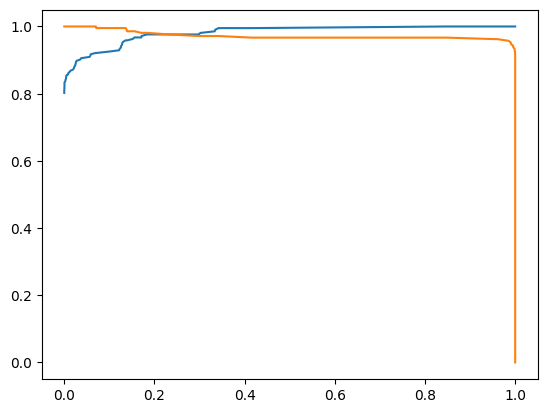

In [108]:
plt.plot(thresholds, precision[1:])
plt.plot(thresholds, recall[1:])

In [123]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

scores = pd.DataFrame()
for t in np.arange(0, 1.01, 0.01):
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    recall = tpr
    precision = tp / (tp + fp)
    f1 = 2 * precision * recall / (precision + recall)
    print(f' t={t} - f1={f1:.5f}')


 t=0.0 - f1=0.88842
 t=0.01 - f1=0.92544
 t=0.02 - f1=0.93157
 t=0.03 - f1=0.94619
 t=0.04 - f1=0.95045
 t=0.05 - f1=0.95045
 t=0.06 - f1=0.95692
 t=0.07 - f1=0.95692
 t=0.08 - f1=0.95672
 t=0.09 - f1=0.95672
 t=0.1 - f1=0.95890
 t=0.11 - f1=0.95890
 t=0.12 - f1=0.95890
 t=0.13 - f1=0.97222
 t=0.14 - f1=0.97196
 t=0.15 - f1=0.97196
 t=0.16 - f1=0.97653
 t=0.17 - f1=0.97653
 t=0.18 - f1=0.97642
 t=0.19 - f1=0.97872
 t=0.2 - f1=0.97872
 t=0.21 - f1=0.97872
 t=0.22 - f1=0.97872
 t=0.23 - f1=0.97872
 t=0.24 - f1=0.97630
 t=0.25 - f1=0.97630
 t=0.26 - f1=0.97630
 t=0.27 - f1=0.97630
 t=0.28 - f1=0.97630
 t=0.29 - f1=0.97630
 t=0.3 - f1=0.97387
 t=0.31 - f1=0.97619
 t=0.32 - f1=0.97619
 t=0.33 - f1=0.97619
 t=0.34 - f1=0.98086
 t=0.35000000000000003 - f1=0.98321
 t=0.36 - f1=0.98321
 t=0.37 - f1=0.98321
 t=0.38 - f1=0.98321
 t=0.39 - f1=0.98321
 t=0.4 - f1=0.98321
 t=0.41000000000000003 - f1=0.98321
 t=0.42 - f1=0.98077
 t=0.43 - f1=0.98077
 t=0.44 - f1=0.98077
 t=0.45 - f1=0.98077
 t=0.46 -

In [127]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [137]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [138]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [145]:
for C in [0.01, 0.1, 1, 10]:
    auc_scores = []
    for train_idx, val_idx in kfold.split(df_full_train[columns]):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = df_train[target].values
        y_val = df_val[target].values
        dv, model = train(df_train[columns], y_train, C)
        y_pred = predict(df_val[columns], dv, model)
        score = roc_auc_score(y_val, y_pred)
        auc_scores.append(score)
        #print(f'roc_auc={roc_auc_score(y_val, y_pred)}')
    print(f'{C, np.mean(auc_scores)}, {np.std(auc_scores)}')

(0.01, 0.9918810292344007), 0.00559887235402738
(0.1, 0.9950557137157224), 0.003954138088244392
(1, 0.9964498276814243), 0.0027434713804377724
(10, 0.9963886109436032), 0.0028151486609295684
